## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
import pandas as pd
os.chdir('..')
import virl
from matplotlib import pyplot as plt
from collections import deque, namedtuple
from operator import attrgetter

import random

from IPython import display

In [2]:
# Keras and backend for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import clone_model

## Agent Implementation

In [3]:
class NNFunctionApproximatorJointKeras():
    """ A basic MLP neural network approximator and estimator using Keras     
    """
    
    def __init__(self, alpha, d_states, n_actions, nn_config, verbose=False):        
        self.alpha = alpha 
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)             
        self.n_actions = n_actions        
        self.d_states = d_states
        self.verbose=verbose # Print debug information        
        self.n_layers = len(nn_config)
        self.model = self._build_model()  
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.d_states, activation='relu'))        
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.alpha, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return


In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'new_state', 'reward'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)               

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memory.pop()

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)   

    def __len__(self):
        return len(self.memory)

In [5]:
def extract_samples(memory, batch_size):
    transitions = memory.sample(batch_size*2)
    best_transitions = sorted(transitions, key=attrgetter("reward"), reverse=True)
    transitions = best_transitions[:batch_size]

    batch = Transition(*zip(*transitions))
    train_rewards = np.array(batch.reward)
    train_states = np.array(batch.state)
    train_new_state = np.array(batch.new_state)
    train_actions = np.array(batch.action)
    return train_rewards, train_states, train_new_state, train_actions

def plot(all_rewards):
    plt.figure(2)
    plt.clf()
    plt.title("Training")
    plt.xlabel("Epsiode")
    plt.ylabel("Total Reward")
    plt.plot(all_rewards)
    plt.pause(0.0001)
    display.clear_output(wait=True)

#  batch_size - number of samples in a batch
#  replay_memory_size - size of the replay buffer
#  nn_config - size of the hidden layers in the MLP [24,24 seems to be a good choice]
def qlearning_nn(batch_size=80, replay_memory_size=600, nn_config=[24,24], num_episodes=100, epsilon_decay=0.9997, output=True, evaluation=False):
    env = virl.Epidemic(stochastic=False, noisy=False)

    memory = ReplayMemory(replay_memory_size)
    n_actions = env.action_space.n
    d_states = env.observation_space.shape[0]
    alpha= 0.001          # learning rate/stepsize, 0.001 seems to be a good choice
    epsilon = 1
    discount_factor = 0.95
    
    # Init the two networks
    policy_network = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
    target_network = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
    target_network.model.set_weights(policy_network.model.get_weights())
    
    best_total_reward = -20
    all_rewards = []
    for episode in range(num_episodes):
        rewards = []
        
        if evaluation:
            if episode == int(num_episodes/4):
                print("--> 25% complete")
            if episode == int(num_episodes/2):
                print("--> 50% complete")
            if episode == int((num_episodes/4)*3):
                print("--> 75% complete")
        
        state = env.reset()
        state = np.reshape(state, [1, d_states])
        exploits = 0
        done = False
        while not done:
            random_number = np.random.random()
            if random_number < epsilon and episode < (num_episodes-5):
                #explore
                action = np.random.choice(n_actions)
            else:
                #exploit
                exploits += 1
                action = policy_network.predict(state)[0]
                action = np.argmax(action)

            new_state, reward, done, i = env.step(action=action)
            new_state = np.reshape(new_state, [1, d_states])
            rewards.append(reward)
            
            memory.push(state, action, new_state, reward)
            

       
            state = new_state
            epsilon *= epsilon_decay
        
            if done:
                if len(memory) >= (batch_size*2):                         
                    # Fetch a batch from the replay buffer and extract as numpy arrays 
                    train_rewards, train_states, train_new_state, train_actions = extract_samples(memory, batch_size)

                    q_values_for_current_state = policy_network.predict(train_states.reshape(batch_size,d_states)) # predict current values for the given states
                    q_values_for_new_state     = target_network.predict(train_new_state.reshape(batch_size,d_states))                    
                    q_values_for_current_state_tmp = train_rewards + discount_factor * np.amax(q_values_for_new_state,axis=1)                
                    q_values_for_current_state[ (np.arange(batch_size), train_actions.reshape(batch_size,).astype(int))] = q_values_for_current_state_tmp                                                                              
                    policy_network.update(train_states.reshape(batch_size,d_states), q_values_for_current_state) # Update the function approximator 
                
                if episode % 100 == 0:
                    target_network.model.set_weights(policy_network.model.get_weights())
                total_reward = np.sum(rewards)
                all_rewards.append(total_reward)
                if output:
                    print("Episode = " + str(episode) + ". Epsilon = " + str(epsilon) + ". Num Exploits = " + str(exploits) + ". Total Reward = " + str(total_reward))
                
                if total_reward > best_total_reward:
                    best_total_reward = total_reward
                    if output:
                        print("Best total reward has been updated to " + str(best_total_reward) + ", for episode " + str(episode))
                        
                plot(all_rewards)
    
    average_of_last_twenty_rewards = np.mean(all_rewards[-20:]) if len(all_rewards) > 20 else np.mean(all_rewards)
    return (all_rewards, average_of_last_twenty_rewards)

In [6]:
def check_epsilon_after(decay, after_episodes):
    return (decay**52)**after_episodes

# def get_ideal_buffer_size_for_fifty_episodes():
#     return (50 * 52)/6.5

print(check_epsilon_after(0.9988005, 25))
print(check_epsilon_after(0.9994, 50))
print(check_epsilon_after(0.9997, 100))
print(check_epsilon_after(0.99997, 1000))

print(check_epsilon_after(0.99997, 500))

0.21007598745303005
0.210037711191485
0.21008689527851565
0.21013115397615528
0.4584006478792927


In [7]:
nn_config = [24,24]
num_episodes = 50
epsilon_decay = 0.9994
print("This setting will result in epsilon = " + str(check_epsilon_after(epsilon_decay, num_episodes)) + " after " + str(num_episodes) + " episodes.")
# 0.21

replay_size = 400
all_values = [60, 70, 80]

eval_all_rewards = []
eval_average_of_last_twenty_rewards = []
for batch_size in all_values:
    print("Starting evaluation with batch size " + str(batch_size))
    all_rewards, average_of_last_twenty_rewards = qlearning_nn(batch_size=batch_size, replay_memory_size=replay_size, nn_config=nn_config, num_episodes=num_episodes, epsilon_decay=epsilon_decay, output=False, evaluation=True)
    print("Average of last twenty rewards = " + str(average_of_last_twenty_rewards))
    eval_all_rewards.append(all_rewards)
    eval_average_of_last_twenty_rewards.append(average_of_last_twenty_rewards)

KeyboardInterrupt: 

# Plot

Episode = 2298. Epsilon = 0.18755489261424532. Num Exploits = 41. Total Reward = -1.3652526484476484


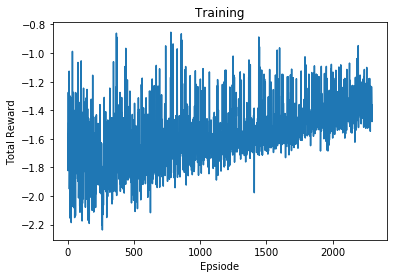

In [ ]:
all_rewards, average_of_last_twenty_rewards = qlearning_nn(batch_size=104, replay_memory_size=1040, nn_config=[24,24], num_episodes=3000, epsilon_decay=0.999986)


Episode = 2999. Epsilon = 0.11258854636337039. Num Exploits = 52. Total Reward = -0.9525276563837316


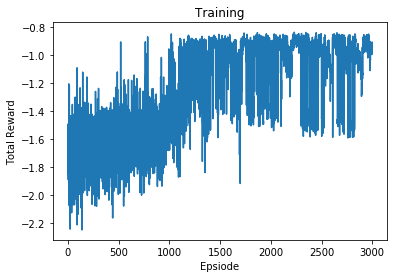

In [9]:
all_rewards, average_of_last_twenty_rewards = qlearning_nn(batch_size=104, replay_memory_size=520, nn_config=[24,24], num_episodes=3000, epsilon_decay=0.999986)
# sampling 2 episodes from replay memory that has 10 episodes

In [10]:
last_50 = np.mean(all_rewards[-50:])

In [11]:
print(last_50)

-0.9416728545398985


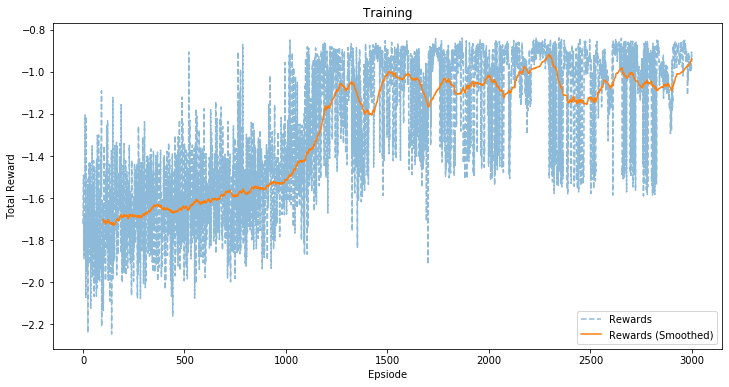

In [19]:
def plot(all_rewards, smoothed_rewards):    
    plt.figure(2, figsize=(12, 6))
    plt.clf()
    plt.title("Training")
    plt.xlabel("Epsiode")
    plt.ylabel("Total Reward")
    plt.plot(all_rewards, '--', alpha=0.5)
    plt.plot(smoothed_rewards)
    plt.legend(["Rewards", "Rewards (Smoothed)"])
    plt.pause(0.0001)
    display.clear_output(wait=True)
    
window_size = 100
smoothed_rewards = pd.Series(all_rewards).rolling(window_size, min_periods=window_size).mean()
plot(all_rewards, smoothed_rewards)